In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path("./data")
path_data.mkdir(exist_ok=True)
path_gz = path_data/"mnist.pkl.gz"

In [3]:
from urllib.request import urlretrieve

In [4]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [5]:
with gzip.open(path_gz) as f: (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [6]:
img_1 = x_train[0]

In [7]:
def chunk(x, n):
    for i in range(0, len(x), n):
        yield x[i: i+n]

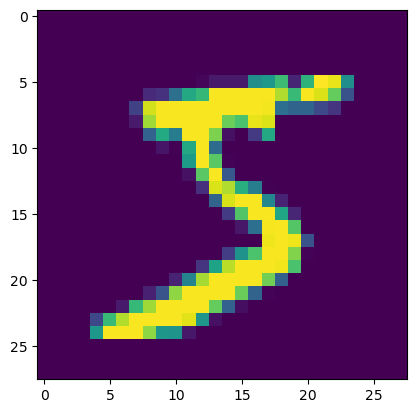

In [8]:
a = list(chunk(img_1, 28))
plt.imshow(a)

## islice

In [9]:
from itertools import islice

In [10]:
def list_to_2d(image_vector):
    it = iter(image_vector)
    return list(iter(lambda: list(islice(it, 28)), []))

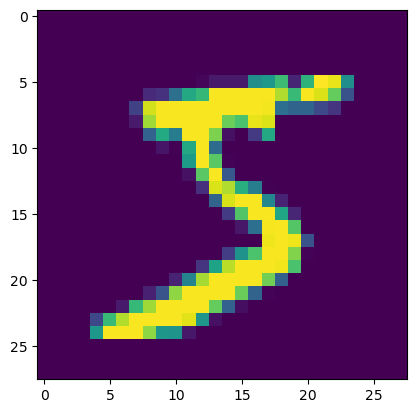

In [11]:
plt.imshow(list_to_2d(img_1))

## Matrix Class

In [12]:
class Matrix:
    def __init__(self, data): self.data=data
    def __getitem__(self, idxs): return self.data[idxs[0]][idxs[1]]
    def size(self): return (len(self.data), len(self.data[0]))

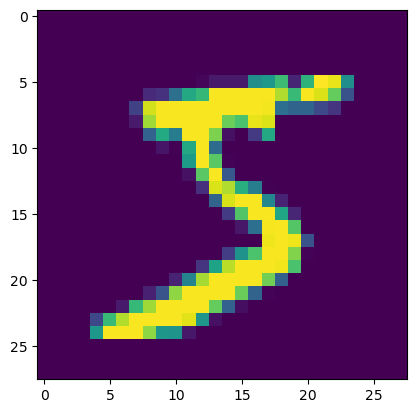

In [13]:
mat_1 = Matrix(list_to_2d(img_1))
plt.imshow(mat_1.data)

## Matmul

In [14]:
def matmul(a, b):
    d_i, d_k = a.size()
    d_k_, d_j = b.size()
    assert d_k == d_k_

    output = []
    
    for i in range(d_i):
        output.append([])
        for j in range(d_j):
            sum_over_k = sum([a[i, k] * b[k, j] for k in range(d_k)])
            output[i].append(sum_over_k)
    return Matrix(output)

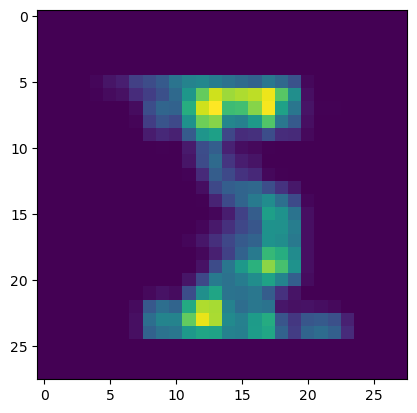

In [15]:
out = matmul(mat_1, mat_1)
plt.imshow(out.data)

## Matmul for Whole Dataset

In [16]:
import torch

In [17]:
x_train = torch.from_numpy(x_train)
x_train.shape

torch.Size([50000, 784])

In [18]:
weights = torch.rand(784, 10)
bias = torch.rand(10)

In [19]:
def matmul_2(a, b):
    ar, ac = a.shape
    br, bc = b.shape

    out = torch.zeros(ar, bc)

    for i in range(ar):
        out[i] = (a[i, :, None] * b).sum(dim=0)

    return out

In [20]:
m1 = x_train[:5]

In [21]:
%timeit -n 50 o1 = matmul_2(m1, weights)

181 μs ± 24.6 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [22]:
%timeit -n 3 o2 = matmul(m1, weights)

532 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [23]:
o1 = matmul_2(m1, weights)
o2 = matmul(m1, weights)

In [24]:
torch.testing.assert_close(o1, torch.tensor(o2.data))

### Now actually for the whole dataset

In [25]:
matmul = matmul_2

In [26]:
%timeit -n 3 matmul(x_train, weights)

1.51 s ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [27]:
%timeit -n 3 x_train @ weights

41.4 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [28]:
xw = matmul(x_train, weights)

## Einsum

In [29]:
%timeit -n 4 torch.einsum("ik, kj->ikj",x_train, weights).sum(1)

450 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [30]:
%timeit -n 4 torch.einsum("ik, kj->ij",x_train, weights)

40.1 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [31]:
torch.testing.assert_close(xw, torch.einsum("ik, kj->ij",x_train, weights))

## On GPU

In [32]:
def matmul_gpu(grid, a, b, c):
    i, j = grid
    if (i < a.shape[0]) and (j<b.shape[1]): 
        temp = 0.
        for k in range(a.shape[1]):
            temp += a[i, k] * b[k, j]
        c[i, j] = temp

In [33]:
def launch_kernel(kernel_func, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y):
            kernel_func((i, j), *args, **kwargs)
            

In [34]:
c = torch.zeros(5, weights.shape[1])
launch_kernel(matmul_gpu, 5, weights.shape[1], x_train[:5], weights, c)

In [35]:
torch.testing.assert_close(xw[:5], c)

I do not have cuda installed, so can't demonstrate how to use cuda here.

The needed changes for cuda are:
- add the `@numba.cuda.jit decorator` to `matmul_gpu` 
- remove `grid` as an argument for `matmul_gpu` replace the first line with `i, j = cuda.grid(2)`
- use `map(cuda.to_device, x_train, ...)` to move the inputs and result to GPU
- launch the kernel with `matmul_gpu[blocks_per_thread, (tpb, tpb)](a, b, c)`
      -`tpb` = threads per block. Will learn more about CUDA later...